# Network Intrusion Detection 

### What is network intrusion detection?

Network Intrusion Detection Systems (NIDS) monitor network traffic to identify malicious activity, such as: 
 - Denial of Service (DoS) attacks
 - Probing/scanning attacks (e.g., port scanning)
 - User-to-root (U2R) attacks (e.g., privilege escalation)
 - Remote-to-local (R2L) attacks (e.g., unauthorized remote login)

Anomaly detection plays a key role by identifying unusual patterns in network traffic that derive from normal behavior. 

### Methods used in this notebook

- Feature selection and preprocessing
 - Gaussian distribution modeling
 - Isolation forest
 - Performance evaluation through precision, recall, F1, and AUC-ROC
 - Autoencoding
 - Reinforcement learning agent to optimize detection thresholds

### The NSL-KDD Dataset

The NSL-KDD dataset is an improved version of the original KDD cup 1999 dataset that contains labeled network traffic data, making it an ideal dataset for anomaly detection experiments. The new and improved dataset addresses some of the issues with the original dataset, such as redundancy and imbalance. 

Each record in the dataset consists of the following data:
- Basic connection features (e.g., duration, protocol type, service)
- Content features (e.g., number of failed login attempts)
- Traffic-based features (e.g., percentage of connections with errors)

Records are labeled into:
- Normal traffic
- DoS attacks
- Probe attacks
- U2R attacks
- R2L attacks

## Load and Preprocess the Data

In [1]:
# Import libraries and tools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from urllib.request import urlretrieve
import os
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

# Define URLs for NSL-KDD dataset
DATASET_URL = "https://www.kaggle.com/datasets/hassan06/nslkdd?select=KDDTrain%2B.txt"
COLUMN_NAMES = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
    'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations',
    'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate',
    'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 
    'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate',
    'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'label', 'difficulty_level'
]

# Download dataset if not available
file_path = 'KDDTrain+.txt'
if not os.path.exists(file_path):
    urlretrieve(DATASET_URL, file_path)

# Load dataset
df = pd.read_csv(file_path, names = COLUMN_NAMES)

# Drop columns not useful for detection
df.drop(columns = ['difficulty_level'], inplace = True)

# convert categorical features into numerical representations
label_encoders = {}

categorical_columns = ['protocol_type', 'service', 'flag', 'label']
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Normalize numerical features
numerical_columns = df.columns[:-1] # excluding the label column
scaler = StandardScaler()
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

# convert labels to binary (0 = normal, 1 = anomaly)
df['label'] = df['label'].apply(lambda x: 0 if x == 11 else 1)

# display the first few rows
df.head(10)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,-0.110249,-0.124706,-0.686785,0.751111,-0.007679,-0.004919,-0.014089,-0.089486,-0.007736,-0.095076,...,-0.818890,-0.782367,-0.280282,0.069972,-0.289103,-0.639532,-0.624871,-0.224532,-0.376387,0
1,-0.110249,2.219312,0.781428,0.751111,-0.007737,-0.004919,-0.014089,-0.089486,-0.007736,-0.095076,...,-1.035688,-1.161030,2.736852,2.367737,-0.289103,-0.639532,-0.624871,-0.387635,-0.376387,0
2,-0.110249,-0.124706,1.087305,-0.736235,-0.007762,-0.004919,-0.014089,-0.089486,-0.007736,-0.095076,...,-0.809857,-0.938287,-0.174417,-0.480197,-0.289103,1.608759,1.618955,-0.387635,-0.376387,1
3,-0.110249,-0.124706,-0.442083,0.751111,-0.007723,-0.002891,-0.014089,-0.089486,-0.007736,-0.095076,...,1.258754,1.066401,-0.439078,-0.383108,0.066252,-0.572083,-0.602433,-0.387635,-0.345084,0
4,-0.110249,-0.124706,-0.442083,0.751111,-0.007728,-0.004814,-0.014089,-0.089486,-0.007736,-0.095076,...,1.258754,1.066401,-0.439078,-0.480197,-0.289103,-0.639532,-0.624871,-0.387635,-0.376387,0
5,-0.110249,-0.124706,1.087305,-2.223581,-0.007762,-0.004919,-0.014089,-0.089486,-0.007736,-0.095076,...,-0.873089,-1.005110,-0.068553,-0.480197,-0.289103,-0.639532,-0.624871,2.874410,2.753914,1
6,-0.110249,-0.124706,1.087305,-0.736235,-0.007762,-0.004919,-0.014089,-0.089486,-0.007736,-0.095076,...,-0.963422,-1.071933,-0.174417,-0.480197,-0.289103,1.608759,1.618955,-0.387635,-0.376387,1
7,-0.110249,-0.124706,1.087305,-0.736235,-0.007762,-0.004919,-0.014089,-0.089486,-0.007736,-0.095076,...,-0.909222,-1.027384,-0.068553,-0.480197,-0.289103,1.608759,1.618955,-0.387635,-0.376387,1
8,-0.110249,-0.124706,1.209656,-0.736235,-0.007762,-0.004919,-0.014089,-0.089486,-0.007736,-0.095076,...,-0.836956,-0.960561,-0.174417,-0.480197,-0.289103,1.608759,1.618955,-0.387635,-0.376387,1
9,-0.110249,-0.124706,1.087305,-0.736235,-0.007762,-0.004919,-0.014089,-0.089486,-0.007736,-0.095076,...,-0.927289,-1.049659,-0.121485,-0.480197,-0.289103,1.608759,1.618955,-0.387635,-0.376387,1


## Exploratory Data Analysis

#### Class Distribution

Dataset shape (125973, 44)
Class Distribution:
label
0    67343
1    58630
Name: count, dtype: int64


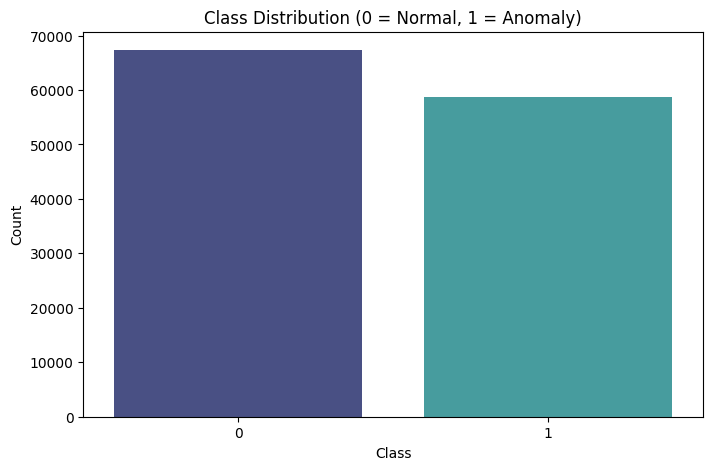

In [73]:
print("Dataset shape", df.shape)
print("Class Distribution:")
print(df['label'].value_counts())

#visualization: Distribution of anomalies vs. normal traffic
plt.figure(figsize = (8,5))
sns.countplot(x=df['label'], palette = 'mako', hue = df['label'], legend = False)
plt.title("Class Distribution (0 = Normal, 1 = Anomaly)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

#### Distirbution of Numerical Features

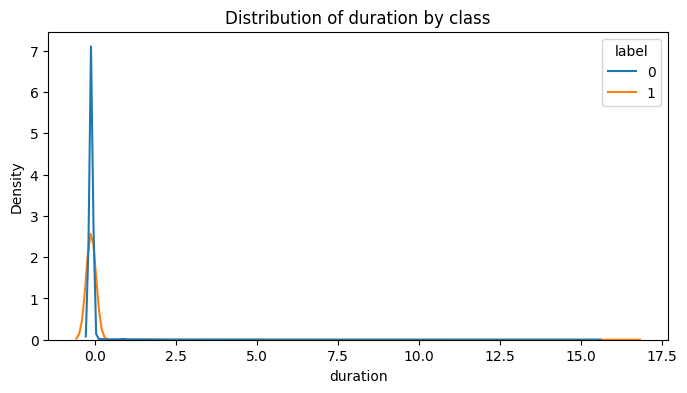

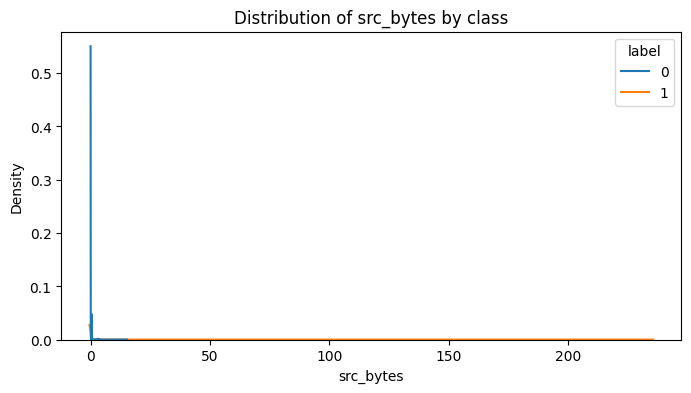

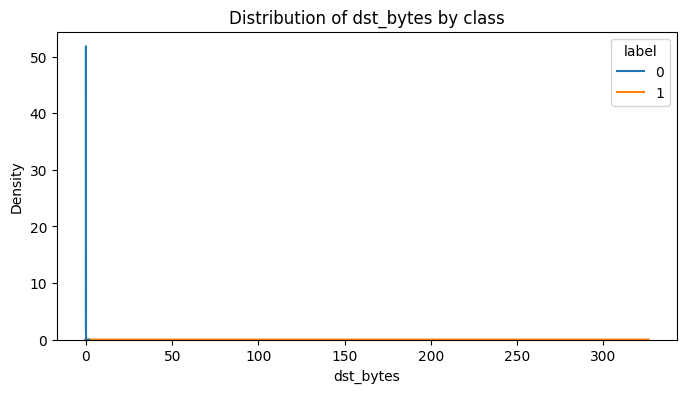

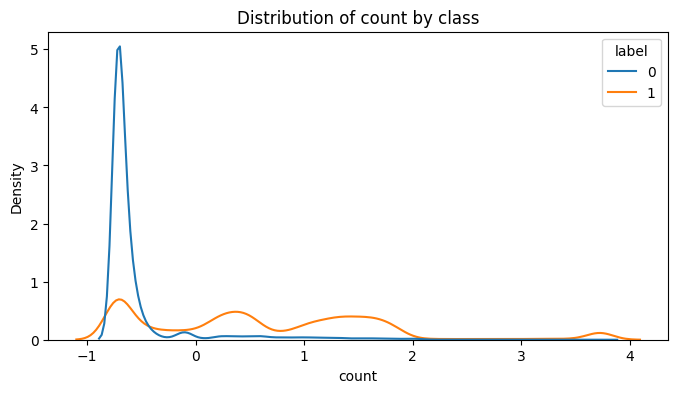

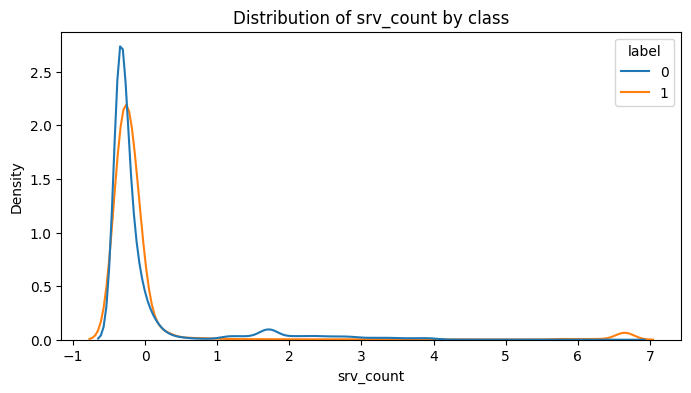

In [74]:
selected_features = ['duration', 'src_bytes', 'dst_bytes', 'count', 'srv_count']
for feature in selected_features:
    plt.figure(figsize = (8,4))
    sns.kdeplot(data = df, x = feature, hue = 'label', common_norm = False)
    plt.title(f"Distribution of {feature} by class")
    plt.show()

Text(0.5, 1.0, 'Feature Correlation Heatmap')

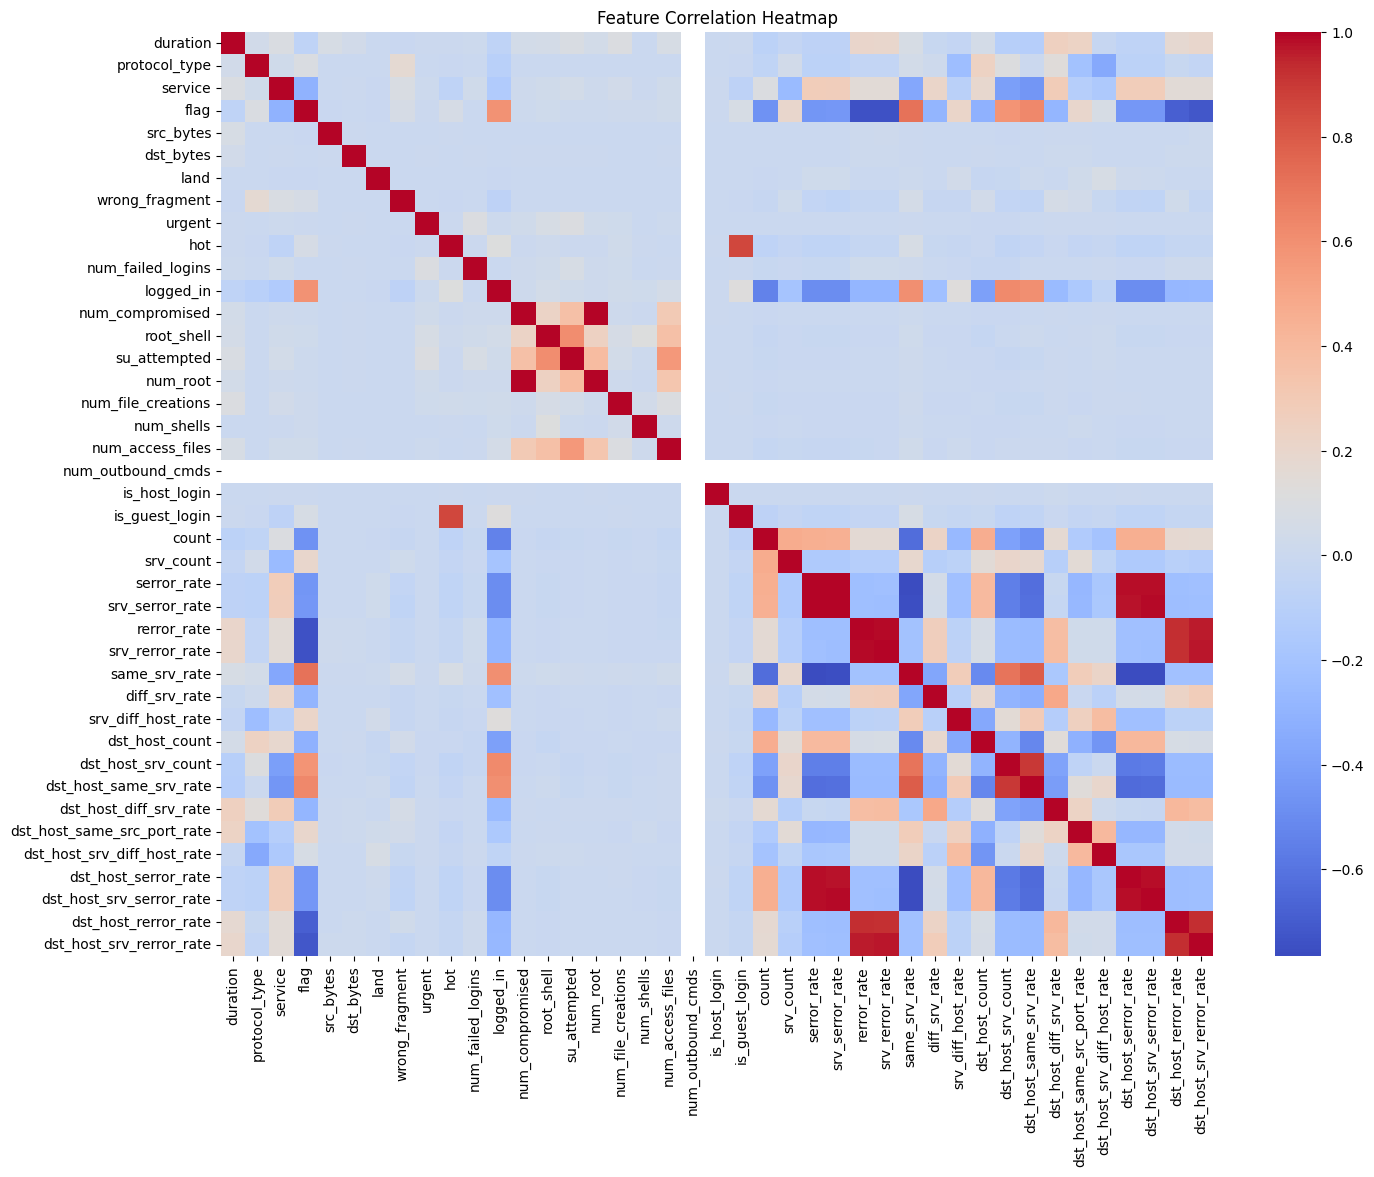

In [4]:
plt.figure(figsize = (16,12))
sns.heatmap(pd.DataFrame(df, columns = numerical_columns).corr(), cmap='coolwarm', annot = False)
plt.title("Feature Correlation Heatmap")

#### Categorical Feature Distributions by Class

`protocol_type` represents the type of protocol used in the connection, it tells you how data is being transmitted, which can influence the likelihood of certain types of attacks. The plot below indicates that while the greatest overlap occurs between normal and anomalous activity for the most typical protocol, other protocol types are overrepresented in the anomalous and normal cases, respectively. 

`service` represents the network service on the destination, like the application or port used. It indicates what type of communication is occurring, which is key for detecting service-specific exploits. The density of labels doesn't seem to differ much between our normal and anomalous use cases for this dataset, but our anomalous distribution seems to have a much longer tail, indicating more varies services employed. 

`flag` represents the status of the connection after it was completed or rejected, which can be critical for spotting failed or suspicious connection patterns. In the plot below, the distribution of anomalous flags seems shifted a bit with respect to the distribution of normal flags. 

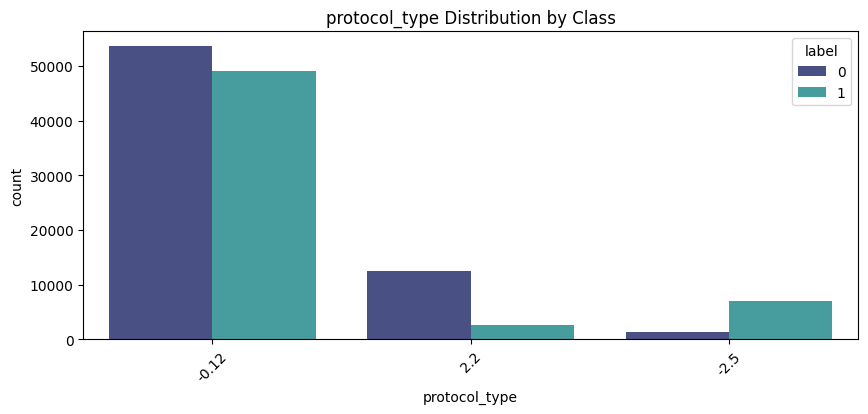

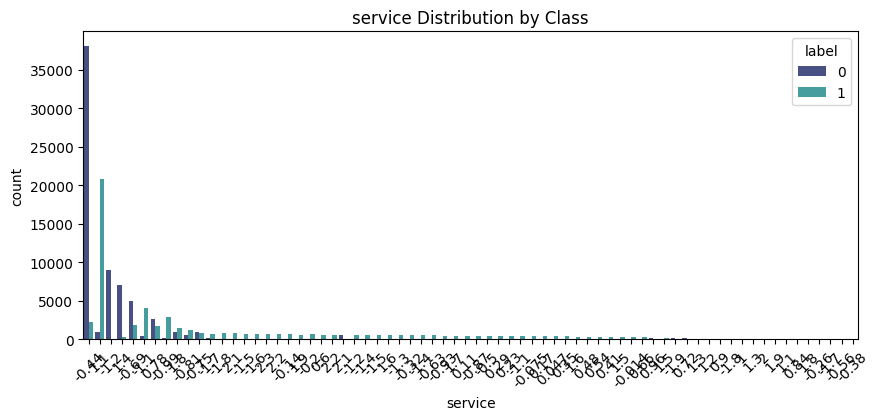

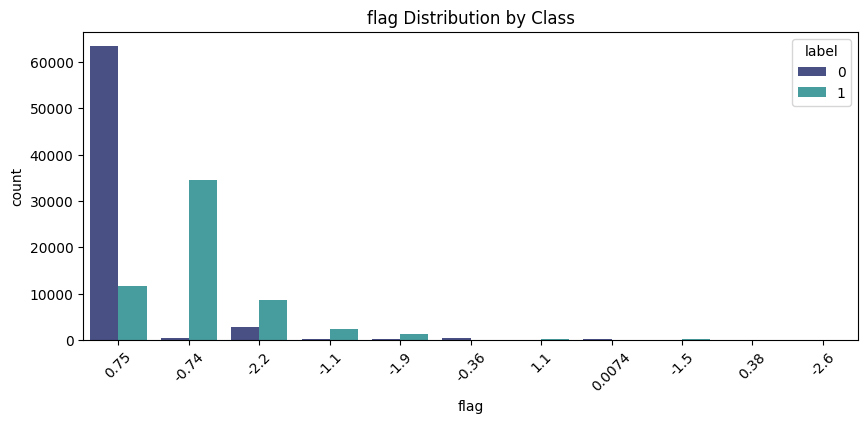

In [75]:
categorical_overview = ['protocol_type', 'service', 'flag']
for cat in categorical_overview:
    plt.figure(figsize=(10, 4))
    value_order = df[cat].value_counts().index.tolist()
    ax = sns.countplot(data=df, x=cat, hue='label', palette='mako', order=value_order)
    ax.set_xticks(range(len(value_order)))
    ax.set_xticklabels([f"{label:.2g}" for label in value_order], rotation = 45)
    plt.title(f"{cat} Distribution by Class")
    plt.show()

## Model Building and Testing

In [6]:
# split the dataset into features and labels
X = df.drop(columns = ['label'])
y = df['label']

#### Isolation Forest Model

An Isolation Forest isolates potentially anomalous observations by selecting a feature, and then randomly selecting a split value between the maximum and minimum values of that feature. The idea is that anomalies are fewer and different from normal observations, so they're easier to isolate and require fewer splits. The IF model is a good choice because of the following features:
- Speed: The IF model has a linear time complexity `(O (n log n))`, which is great for larger datasets
- Assumption Free: It doesn't assume Gaussian distributions, which makes it a little more robust to real-world quirks of data
- Unsupervised: This method works without needing labeled anomalous data
- Interpretable: Anomalies in this method are identified based on how quickly they can be isolated, which often aligns with intuitive "oddness"


In [7]:
# Train the Isolation Forest Model
iso_forest = IsolationForest(n_estimators = 200, max_features = 0.8, max_samples = 'auto', contamination = 0.2,  random_state = 42)
iso_forest.fit(X)
df['iso_forest_anomaly'] = iso_forest.predict(X)
df['iso_forest_anomaly'] = df['iso_forest_anomaly'].apply(lambda x: 1 if x == -1 else 0)

#### Support Vector Machine Model

The one-class Support Vector Machine (SVM) model learns a boundary that encloses the normal data points in a high-dimensional space. Anything that lies outside of that boundary is considered an anomaly. The SVM model is a good choice because of the following features:
- Handling of high-dimensional data: The kernel trick of SVM allows it to detect complex, non-linear boundaries in datasets
- Focus on the "normal" class: By training only on the "normal" data, it models the support of the distribution
- Flexibility: The `nu` parameter helps control the tradeoff between false-positives and negatives


In [8]:
# Train one-class SVM model
one_svm = OneClassSVM(nu = 0.1, kernel = 'rbf', gamma = 'auto')
one_svm.fit(X)
df['svm_anomaly'] = one_svm.predict(X)
df['svm_anomaly'] = df['svm_anomaly'].apply(lambda x: 1 if x == -1 else 0)

In [9]:
# Compare models
print('Isolation Forest Anomalies:')
print(df['iso_forest_anomaly'].value_counts())
print('One-Class SVM Anomalies:')
print(df['svm_anomaly'].value_counts())

Isolation Forest Anomalies:
iso_forest_anomaly
0    100778
1     25195
Name: count, dtype: int64
One-Class SVM Anomalies:
svm_anomaly
0    113380
1     12593
Name: count, dtype: int64


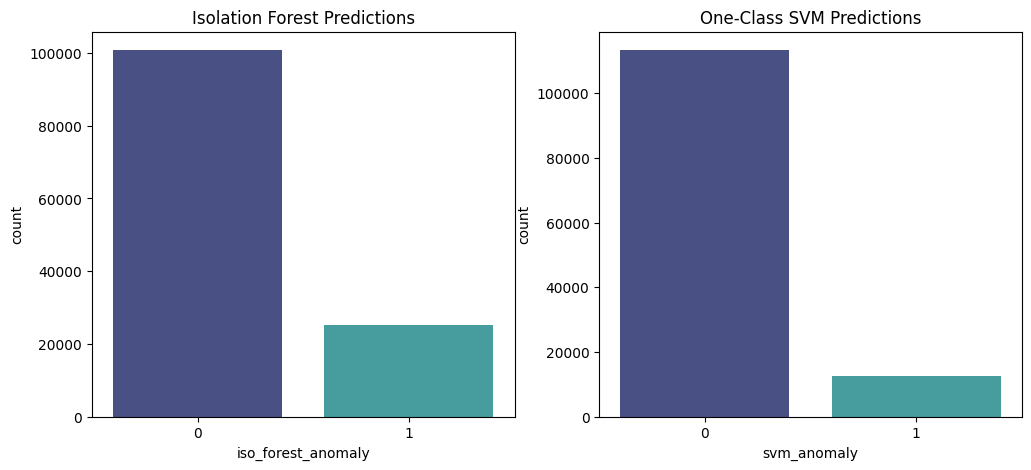

In [76]:
# visualization: model predictions
fig, axes = plt.subplots(1, 2, figsize = (12, 5))
sns.countplot(x = df['iso_forest_anomaly'], palette = 'mako', hue = df['iso_forest_anomaly'], legend = False, ax = axes[0])
axes[0].set_title('Isolation Forest Predictions')

sns.countplot(x = df['svm_anomaly'], palette = 'mako', hue = df['svm_anomaly'], legend = False, ax = axes[1])
axes[1].set_title('One-Class SVM Predictions')
plt.show()

#### Model Evaluation

The models in this notebook are evaluated on the following criteria:
- Confusion matrix: Efficient breakdown of how well the model distinguishes between normal and anomalous
- Accuracy: Overall correct predictions
- Precision: How many predicted anomalies are actually anomalous
- Recall (Sensitivity): How many actual anomalies were caught by the model?
- F1 Score: Harmonic mean of precison and recall

In [11]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_curve, auc
def evaluate_model(y_true, y_pred, model_name):
    print(f"\nEvaluation for {model_name}:")
    print(confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred, digits = 4))

# evaluate isolation forest 
evaluate_model(df['label'], df['iso_forest_anomaly'], "Isolation Forest")

# evaluate SVM
evaluate_model(df['label'], df['svm_anomaly'], "One-Class SVM")


Evaluation for Isolation Forest:
[[59766  7577]
 [41012 17618]]
              precision    recall  f1-score   support

           0     0.5930    0.8875    0.7110     67343
           1     0.6993    0.3005    0.4204     58630

    accuracy                         0.6143    125973
   macro avg     0.6462    0.5940    0.5657    125973
weighted avg     0.6425    0.6143    0.5757    125973


Evaluation for One-Class SVM:
[[62462  4881]
 [50918  7712]]
              precision    recall  f1-score   support

           0     0.5509    0.9275    0.6912     67343
           1     0.6124    0.1315    0.2166     58630

    accuracy                         0.5571    125973
   macro avg     0.5817    0.5295    0.4539    125973
weighted avg     0.5795    0.5571    0.4703    125973



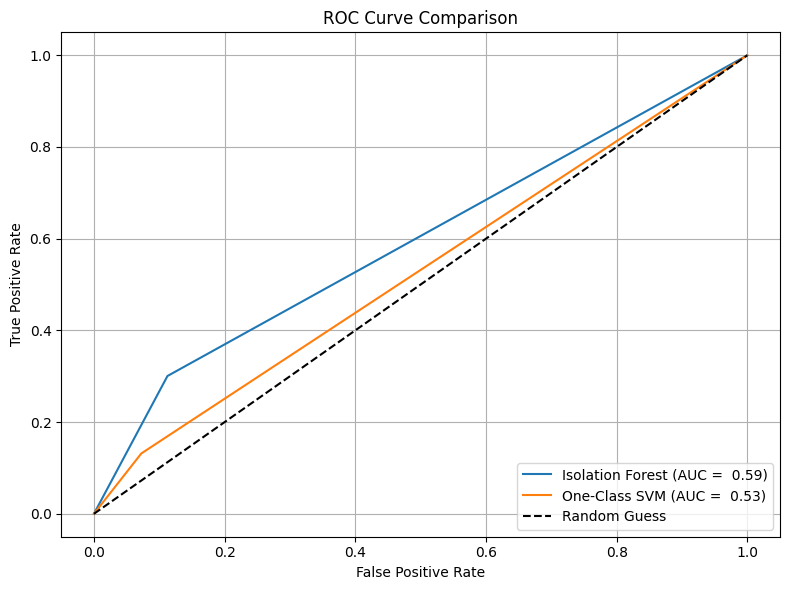

In [77]:
# ROC curves
fpr_if, tpr_if, _ = roc_curve(df['label'], df['iso_forest_anomaly'])
fpr_svm, tpr_svm, _ = roc_curve(df['label'], df['svm_anomaly'])
auc_if = auc(fpr_if, tpr_if)
auc_svm = auc(fpr_svm, tpr_svm)

plt.figure(figsize = (8,6))
plt.plot(fpr_if, tpr_if, label = f"Isolation Forest (AUC = {auc_if: .2f})")
plt.plot(fpr_svm, tpr_svm, label = f"One-Class SVM (AUC = {auc_svm: .2f})")
plt.plot([0, 1], [0, 1], 'k--', label = "Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend(loc = "lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

#### Parameter Search for IF Model

The above results suggest that the IF model might be able to provide a better fit for the data, so we'll proceed with a parameter search to find the best model specification for this data. 

In [13]:
from sklearn.model_selection import ParameterGrid

param_grid = {
    'n_estimators' : [100, 200],
    'max_samples' : ['auto', 0.6],
    'contamination' : [0.1, 0.2],
    'max_features' : [1.0, 0.8]
}

grid = ParameterGrid(param_grid)
results = []

for params in grid: 
    model = IsolationForest(**params, random_state = 42)
    model.fit(X)
    preds = model.predict(X)
    preds = np.where(preds == -1, 1, 0)
    f1 = f1_score(y, preds)
    auc_score = auc(*roc_curve(y, preds)[:2])
    results.append((params, f1, auc_score))

# sort and print top results
sorted_results = sorted(results, key = lambda x: x[1], reverse = True)
print("Top Isolation Forest Configurations by F1 Score:")
for i, (params, f1_score, auc_score) in enumerate(sorted_results[:5]):
    print(f"{i + 1}. Params: {params} | F1 score: {f1: .4f} | AUC: {auc_score: .4f}")
    

Top Isolation Forest Configurations by F1 Score:
1. Params: {'contamination': 0.2, 'max_features': 0.8, 'max_samples': 'auto', 'n_estimators': 200} | F1 score:  0.3536 | AUC:  0.5940
2. Params: {'contamination': 0.2, 'max_features': 0.8, 'max_samples': 'auto', 'n_estimators': 100} | F1 score:  0.3536 | AUC:  0.5899
3. Params: {'contamination': 0.2, 'max_features': 1.0, 'max_samples': 'auto', 'n_estimators': 100} | F1 score:  0.3536 | AUC:  0.5893
4. Params: {'contamination': 0.2, 'max_features': 1.0, 'max_samples': 'auto', 'n_estimators': 200} | F1 score:  0.3536 | AUC:  0.5845
5. Params: {'contamination': 0.2, 'max_features': 1.0, 'max_samples': 0.6, 'n_estimators': 100} | F1 score:  0.3536 | AUC:  0.5525


The results of our unsupervised method, with noisy complex data like in the NSL-KDD set, are pretty good. We have found some meaningful patterns in the data, but to extend our model further, we should employ some deep-learning methods.

## Implementing an Autoencoder for Deep Learning

An autoencoder is a type of neural network that learns to compress the data (encode), and then reconstruct it (decode) as accurately as possible. The goal of the method is to learn a compressed representation of the data that retains only the most important features of "normal" observations, reconstruction will then be poor for anomalous events, and can be identified through their greater loss. 

In [14]:
#pip install torch

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



In [15]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split

In [28]:
# Prepare data for the autoencoder
X_tensor = torch.tensor(df[df['label'] == 0].drop(columns = ['label']).values, dtype = torch.float32)
X_all = torch.tensor(df.drop(columns = ['label']).values, dtype = torch.float32)
y_all = torch.tensor(df['label'].values, dtype = torch.int64)

In [29]:
# autoencoder model definition
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, 8)
        )
        self.decoder = nn.Sequential(
            nn.Linear(8, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded      

In [30]:
# Training setup
input_dim = X_tensor.shape[1]
autoencoder = Autoencoder(input_dim)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr = 0.001)
dataloader = DataLoader(TensorDataset(X_tensor), batch_size = 256, shuffle = True)

In [31]:
# Train the autoencoder
for epoch in range(50):
    total_loss = 0
    for batch in dataloader:
        x_batch = batch[0]
        optimizer.zero_grad()
        outputs = autoencoder(x_batch)
        loss = criterion(outputs, x_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"epoch {epoch+1}, loss: {total_loss / len(dataloader): 0.6f}")

epoch 1, loss:  0.456131
epoch 2, loss:  0.277789
epoch 3, loss:  0.224603
epoch 4, loss:  0.219027
epoch 5, loss:  0.200178
epoch 6, loss:  0.184461
epoch 7, loss:  0.166558
epoch 8, loss:  0.157692
epoch 9, loss:  0.158176
epoch 10, loss:  0.162696
epoch 11, loss:  0.160689
epoch 12, loss:  0.098714
epoch 13, loss:  0.089372
epoch 14, loss:  0.095802
epoch 15, loss:  0.104752
epoch 16, loss:  0.094768
epoch 17, loss:  0.055469
epoch 18, loss:  0.051850
epoch 19, loss:  0.063491
epoch 20, loss:  0.067958
epoch 21, loss:  0.047646
epoch 22, loss:  0.047954
epoch 23, loss:  0.051503
epoch 24, loss:  0.054262
epoch 25, loss:  0.079180
epoch 26, loss:  0.056428
epoch 27, loss:  0.069735
epoch 28, loss:  0.071169
epoch 29, loss:  0.055695
epoch 30, loss:  0.036737
epoch 31, loss:  0.042351
epoch 32, loss:  0.037874
epoch 33, loss:  0.042794
epoch 34, loss:  0.048258
epoch 35, loss:  0.086219
epoch 36, loss:  0.059959
epoch 37, loss:  0.035508
epoch 38, loss:  0.029446
epoch 39, loss:  0.03

In [33]:
# calculate reconstruction error on entire dataset
with torch.no_grad():
    reconstructed = autoencoder(X_all)
    loss_per_sample = torch.mean((reconstructed - X_all) ** 2, dim = 1).numpy()


In [35]:
# Evaluate encoder
print("\nEvaluation for Autoencoder:")
print(confusion_matrix(y_all, predictions))
print(classification_report(y_all, predictions, digits = 4))


Evaluation for Autoencoder:
[[67127   216]
 [52547  6083]]
              precision    recall  f1-score   support

           0     0.5609    0.9968    0.7179     67343
           1     0.9657    0.1038    0.1874     58630

    accuracy                         0.5812    125973
   macro avg     0.7633    0.5503    0.4526    125973
weighted avg     0.7493    0.5812    0.4710    125973



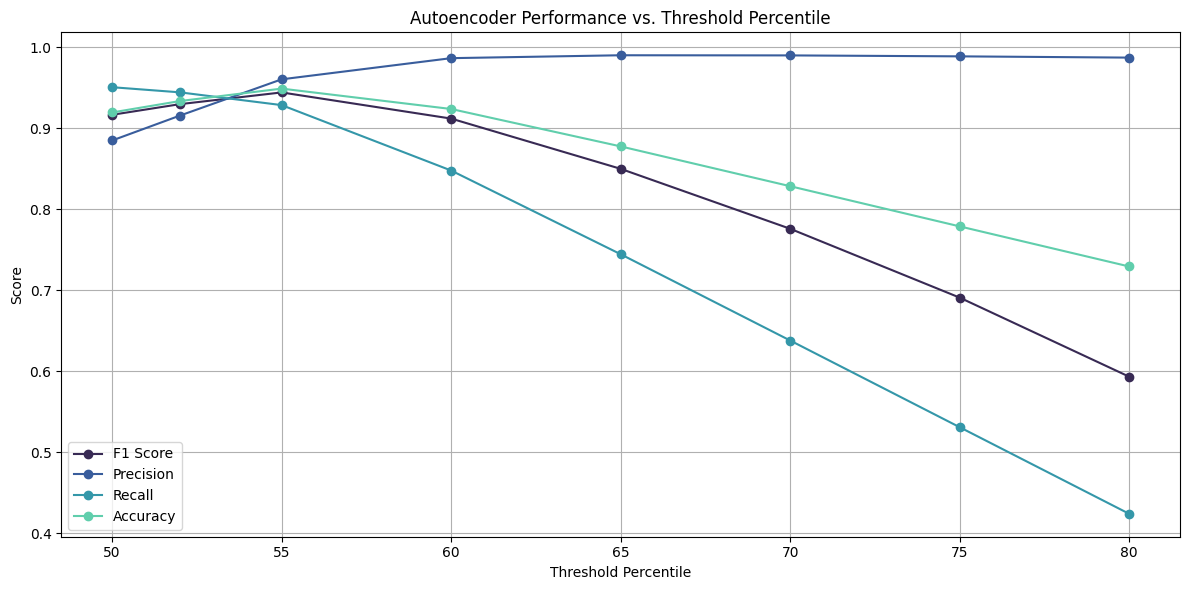

In [71]:
# try different values of threshold and evaluate
from sklearn.metrics import f1_score
verbose = 0
thresholds = [50, 52, 55, 60, 65, 70, 75, 80]
metrics_summary = []
for p in thresholds:
    threshold = np.percentile(loss_per_sample, p)
    predictions = (loss_per_sample > threshold).astype(int)
    cm = confusion_matrix(y_all, predictions)
    report = classification_report(y_all, predictions, output_dict = True, digits = 4)
    f1 = report['1']['f1-score']
    precision = report['1']['precision']
    recall = report['1']['recall']
    accuracy = report['accuracy']
    metrics_summary.append({'Threshold Percentile': p, 'F1 Score': f1, 'Precision': precision, 'Recall': recall, 'Accuracy': accuracy})
    if verbose:
        print(f"\nEvaluation at {p}th percentile threshold:")
        print(cm)
        print(classification_report(y_all, predictions, digits = 4))

# convert to a df and plot
metrics_df = pd.DataFrame(metrics_summary)

plt.figure(figsize = (12, 6))
colors = sns.color_palette('mako', n_colors = 4)
for idx, metric in enumerate(['F1 Score', 'Precision', 'Recall', 'Accuracy']):
    plt.plot(metrics_df['Threshold Percentile'], metrics_df[metric], marker = 'o', label = metric, color = colors[idx])
plt.title('Autoencoder Performance vs. Threshold Percentile')
plt.xlabel('Threshold Percentile')
plt.ylabel('Score')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

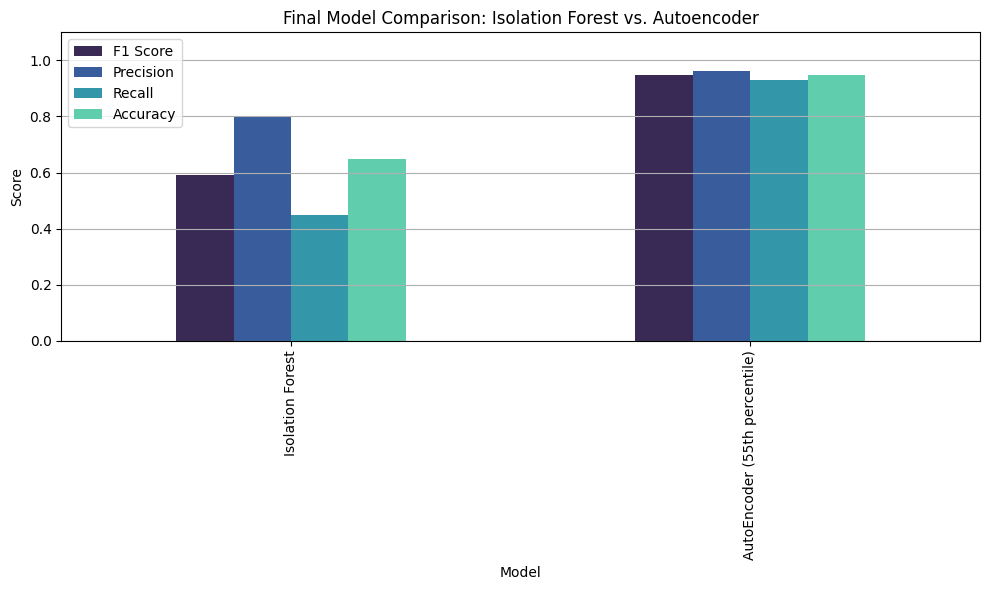

In [72]:
# Final comparison with Isolation Forest model and AutoEncoder
comparison_df = pd.DataFrame({
    'Model': ['Isolation Forest', 'AutoEncoder (55th percentile)'],
    'F1 Score': [0.59, 0.9490], 
    'Precision': [0.80, metrics_df[metrics_df['Threshold Percentile'] == 55]['Precision'].values[0]],
    'Recall': [.45, metrics_df[metrics_df['Threshold Percentile'] == 55]['Recall'].values[0]],
    'Accuracy': [0.65, metrics_df[metrics_df['Threshold Percentile'] == 55]['Accuracy'].values[0]]
})

# Bar plot for final comparison
comparison_df.set_index('Model')[['F1 Score', 'Precision', 'Recall', 'Accuracy']].plot(
    kind = 'bar', figsize = (10,6), color = colors)
plt.title('Final Model Comparison: Isolation Forest vs. Autoencoder')
plt.ylabel('Score')
plt.ylim(0, 1.1)
plt.grid(True, axis = 'y')
plt.tight_layout()
plt.show()
    